# Structural Similarity

During this seminar we will:
1. Consider some node similarity measures, particularly: *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance*
2. Take a look at *[Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* node reordering procedure
3. Calculate *Assortative mixing coefficient* for some **[Game Of Thrones](http://cdn.meme.am/instances/55597956.jpg)** network

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spt
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import random as rnd
%matplotlib inline

### Task 1 - Similarities Calculation

1. Calculate *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance* for some toy-network (Zachary again?) and for [Les Miserables](http://www-personal.umich.edu/~mejn/netdata/lesmis.zip) dataset
2. Visualize them

**HINT:**
For correlation coeficient you can use *np.corrcoef()*, for the distances you may implement them on your own or use *scipy.spatial.distance.pdist()*

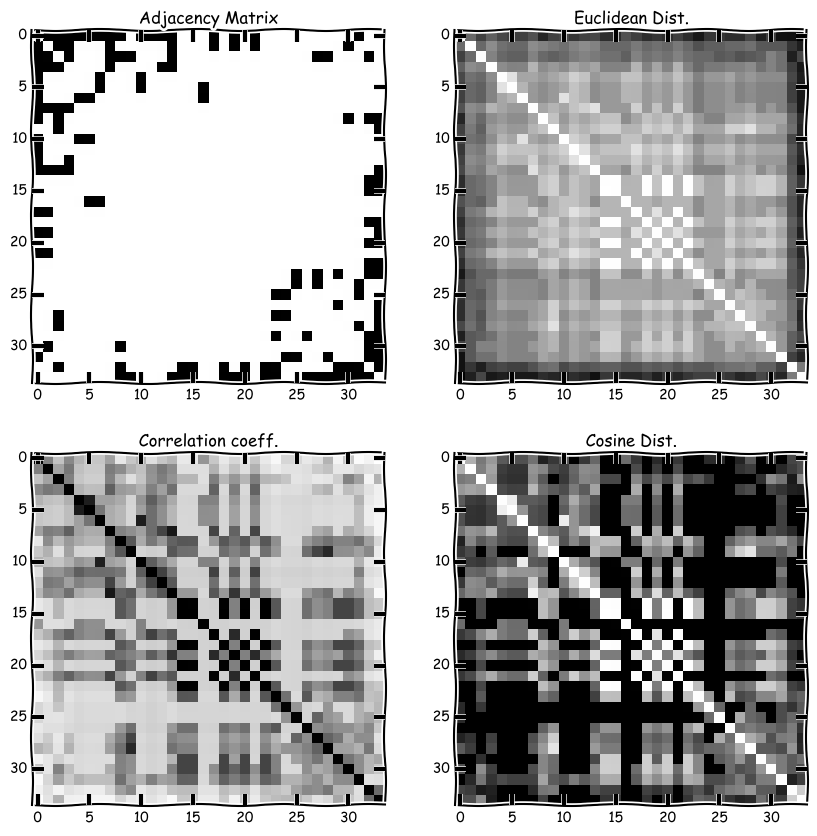

In [2]:
G = nx.karate_club_graph()
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
plotDist(A)

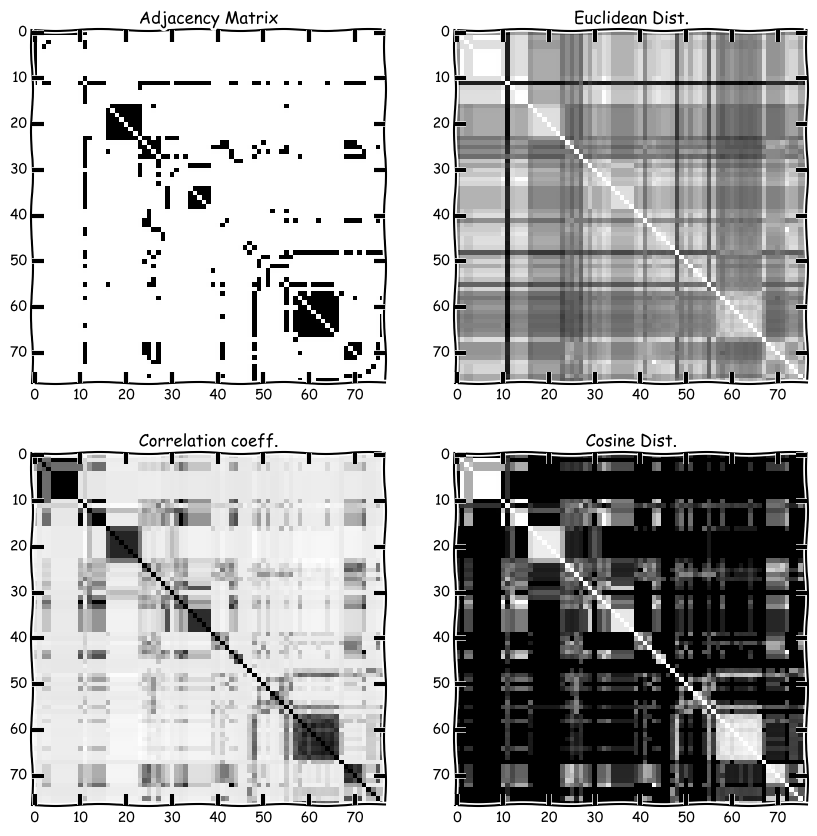

In [3]:
G = nx.read_gml('lesmis.gml')
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

plotDist(A)

### Task 2 - Node Reordering

Without special preprocess procedures graph adjacency matrix can look very noisy and hide network's structure (just look at the matrices above). Offcourse usually you don't know the structure itself (communities, groups of closelly connected nodes, etc.) unless it is given, however there are some procedures of node reordering that provides a better view of the network's adjacency matrix.

*[Reverse Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* finds permutation of the nodes that minimizes the **bandwidth** of the matrix, which is calculated as:
$$ \theta = \max_{a_{ij} > 0}|i-j|$$
Unformally, this algorithm puts some *mass* on the diagonal of adjacency matrix.

Run this reordering with *nx.utils.reverse_cuthill_mckee_ordering(G)* and compare with the results above

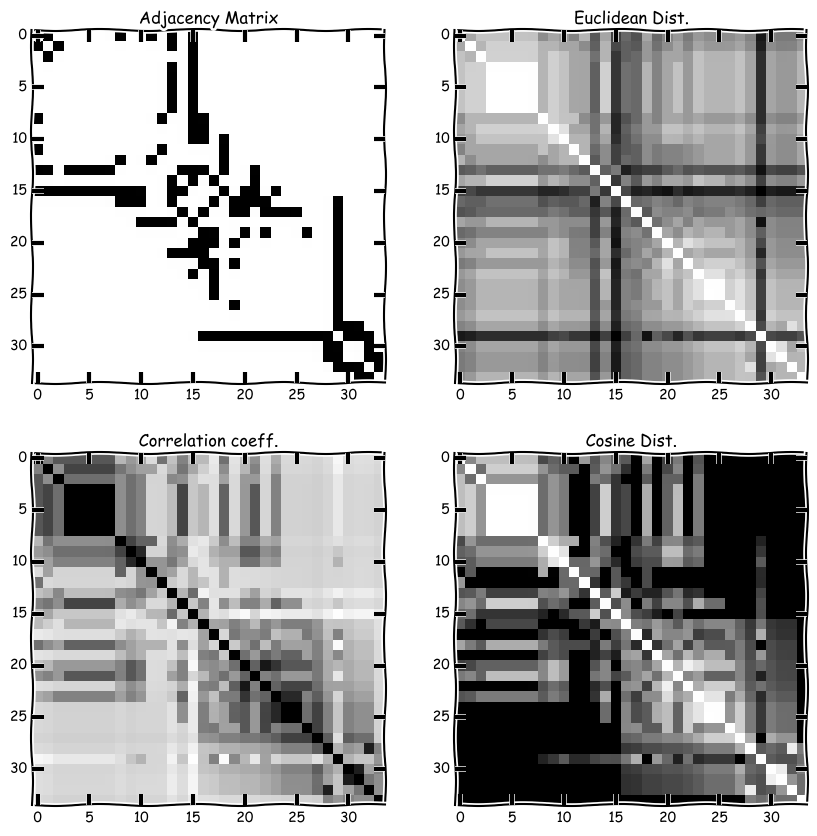

In [4]:
# Put your code here
#
#
G = nx.karate_club_graph()

# run procedure
cm = nx.utils.reverse_cuthill_mckee_ordering(G)
# get permutation
l = [n for n in cm]
l

A = nx.to_numpy_matrix(G)
A = np.asarray(A)
# apply reordering
A = A[np.ix_(l,l)]

plotDist(A)

###  Task 3 - Assortative Mixing

For this task you should download some data, convert it to network and calculate assortative mixing coefficient. Particularly, download [*GOT data*](https://github.com/FutureUnleashed/OSS/tree/master/Neo4j/GOT_Tree): [*characters*](https://www.hse.ru/data/2016/03/15/1127718485/characters.csv) and [*events*](https://www.hse.ru/data/2016/03/15/1127718470/events.csv) datasets.

The first dataset provides information on characters of the Game Of Thrones universe. The second one -- describes some events that have occured with them during the story. We are interested in **killing** events since they can be considered as binary relations and consequently -- graphs. 
The attribute wrt which we are going to compute assortative mixing is called "Team".

We will explore datasets with *pandas* module. The list of usefull functions:
* read_csv()
* characters.head()
* dropna
* set_index('characterID')['Team'].to_dict()
* events[events['event'] == 'killed']

In [5]:
# Put your code here
#
#
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')

In [6]:
characters.head()

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
0,2,Addam Marbrand,Lannister,0,0,0,knight,Ser
1,1894,Adrack Humble,Greyjoy,0,0,0,NaN,NaN
2,7,Aegon Frey (Jinglebell),Frey (North),0,0,0,NaN,NaN
3,8,Aegon I Targaryen,Targaryen,1,0,0,King of the Seven Kingdoms,King
4,12,Aegon Targaryen,Targaryen,1,0,0,prince,Prince


In [7]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

In [8]:
kill_events.head()

,characterID,event,withID
7,1808,killed,2068.0
9,1825,killed,1808.0
25,557,killed,456.0
289,1186,killed,1528.0
518,755,killed,629.0


In [9]:
G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [10]:
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]

In [11]:
nx.set_node_attributes(G, 'Team', ch_team)

In [12]:
nx.assortativity.attribute_assortativity_coefficient(G, 'Team')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'Team')
as_dict

{'Bolton (Lannister)': {},
 'Bolton (North)': {'Bolton (Lannister)': 1,
  'Greyjoy': 1,
  'Stark': 3,
  'none': 1},
 'Brave Companions': {'Lannister': 2, 'none': 1},
 'Citadel': {},
 'Drogo': {'Drogo': 1, 'Targaryen': 1},
 'Essos': {'Targaryen': 2},
 'Faceless Men': {'Citadel': 1, 'Lannister': 2},
 'Frey (Lannister)': {},
 'Frey (North)': {'Stark': 3},
 'Greyjoy': {'Greyjoy': 4,
  'Stark': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 1},
 'Lannister': {'Frey (Lannister)': 2,
  'Lannister': 1,
  'Robert': 2,
  'Stark': 4,
  'none': 1},
 'Littlefinger': {'Littlefinger': 1, 'Robert': 1},
 'Martell': {'Robert': 1},
 'Night Watch': {'Night Watch': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 5},
 'Red God': {'Renly': 2, 'Stannis': 4},
 'Renly': {'Brave Companions': 3, 'Stark': 1, 'none': 1},
 'Robert': {'Brave Companions': 2,
  'Essos': 1,
  'Martell': 1,
  'Robert': 5,
  'Second Sons': 1,
  'Stark': 4},
 'Second Sons': {},
 'Stannis': {},
 'Stark': {'Bolton (Lannister)': 1,
  'Brav

# Home Task for Testing Assortativity

1. Experiment with GoT data, use different similarity metrics. Explain the results. You may choose another dataset on any TV channel serialization.

2. Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later.
Explain this process.

3. Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the *degree correlation coefficient (assortativity)* in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.


# Solution

### Task 1. 
Experiment with GoT data, use different similarity metrics. Explain the results.

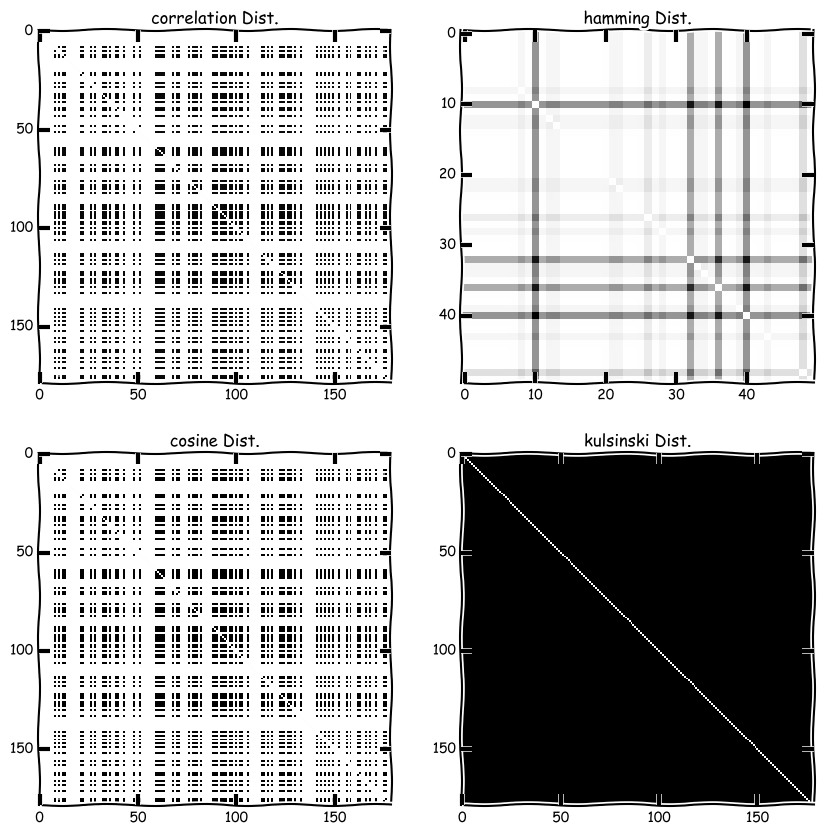

In [13]:
A = nx.to_numpy_matrix(G, dtype=int)

A = np.asarray(A)

def plotDist1(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    
    dVec = spt.distance.pdist(A, metric = 'correlation')
    D = spt.distance.squareform(dVec)
    ax[0, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('correlation Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'hamming')
    D = spt.distance.squareform(dVec)[:50,:50]
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('hamming Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('cosine Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'kulsinski')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('kulsinski Dist.')
    
plotDist1(A)

In [14]:
kill_events.iloc[[10,32,36]]


,characterID,event,withID
765,1621,killed,1140.0
1534,420,killed,1371.0
1573,1812,killed,791.0


In [15]:
characters.loc[characters['characterID'] == 1621]

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
250,1621,Syrio Forel,Stark,0,0,0,NaN,NaN


In [16]:
characters.loc[characters['characterID'] == 420]

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
67,420,Donella Manderly,Stark,0,0,0,NaN,Lady


In [17]:
characters.loc[characters['characterID'] == 1812]

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
283,1812,Weese,Lannister,0,0,0,NaN,NaN


1. We can conclude that there are no suicide.
2. By hamming distance we can emphasize characters that has number 10,32,36 (Syrio Forel Stark, Donella Manderly Stark, Weese Lannister).

### Task 2
Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later.
Explain this process.

Let's consider the emergence of new social network:
0. Let some guys (m0) who know each other have done excellent social network. All of them are in network;
0. They invite other frinds to network, who know several of them. New guys do the same...(new users with preferential attachment);
0. This network is beginning popular and new people join.

        On these steps we have increase of assortativity.

0. People are losing interest to this network and to friends (saturation point). So they begin to leave it or remove some friends.

        On this step assortativity is decreasing.


In [18]:
#n_steps - steps number
#step - number of iterations in one step
#m0 - number of initial guys
#n - degree of new node
#m_sat - number of nodes in saturation point
#del_perc - proportion of removed edges after saturation point
#p_leave - probability of one guy leave network for the one iteration


def Model(n_steps, step = 5, m0=15, n=5, m_sat=100, del_perc=0.05, p_leave=0.5):
    #initial complete graph
    G=nx.complete_graph(m0)
    nodes = G.nodes()
    
    r_sample = [nx.degree_assortativity_coefficient(G)]
    N_sample = [m0]
    prob = np.ones(m0)
    
    for i in xrange(m0, m0+n_steps*step):
        
        deg = G.degree()
        deg = np.asarray(deg.values())
        prob = deg*1./np.sum(deg)
        G.add_node(i)
        
        #new user
        for j in rnd.sample(nodes,n):
            np.random.choice(nodes, p=prob)
            G.add_edge(i,j)
        nodes.append(i)
        
        #saturation point
        if i > m_sat:
            #leaving
            if rnd.random <= p_leave:
                nn = rnd.choice(nodes)
                G.remove_node(nn)
                nodes.remove(nn)
            #friend deleting
            del_num = int(G.number_of_edges()*del_perc)
            for nn in rnd.sample(G.edges(),del_num):
                G.remove_edge(nn[0],nn[1])
        
        if (i-m0-1)%step == 0:
            r_sample.append(nx.degree_assortativity_coefficient(G))
            N_sample.append(i+1)
            
    return r_sample,N_sample

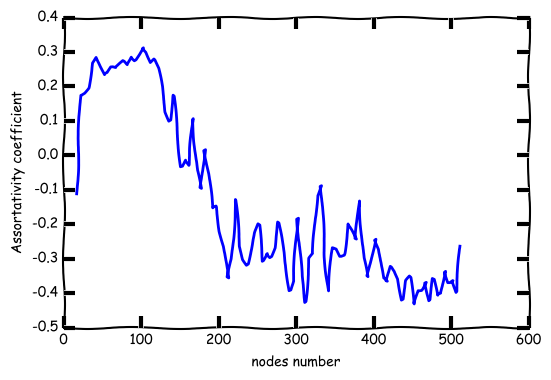

In [19]:
M = Model(100)
plt.plot(M[1], M[0])
plt.xlabel('nodes number')
plt.ylabel('Assortativity coefficient')

### Task 3

Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the *degree correlation coefficient (assortativity)* in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.

Let's take BA model.

In [20]:
def Model_BA(m0, N):
    
    G = nx.complete_graph(m0)
    nodes = range(m0)
    
    deg = np.asfarray(G.degree().values())
    N_e_ov = G.number_of_edges()
    prob = deg/(2*N_e_ov)
    N_e_for_choise = range(1,m0+1)
    
    for i in xrange(m0,N):
        G.add_node(i)
        N_e = rnd.choice(N_e_for_choise)
        deg = np.append(deg,N_e)
        nodes_from_connect = []
        j = 0
        while j < N_e:
            node = np.random.choice(nodes, p=prob)

            if node not in nodes_from_connect:
                nodes_from_connect.append(node)
                G.add_edge(i,node)
                deg[i] += 1
                N_e_ov += 1
                j += 1
        
        nodes.append(i)
        prob = deg/(2.*N_e_ov)
        
    return G

In [21]:
def bio_net(m0, N, del_prop):
    G = Model_BA(m0, N)
    N_removed = int(G.number_of_nodes()*del_prop)
    deg_high = G.degree()
    deg_high = sorted(deg_high, key = deg_high.get, reverse = True)
    deg_high = deg_high[:N_removed]
    G.remove_nodes_from(deg_high)
    return G

def bio_sample(m0, N, N_steps, step_del = 0.005):
    G = Model_BA(m0, N)
    G_sample = [G]
    del_sample = np.arange(0,(N_steps+1)*step_del,step_del)
    N_removed = int(G.number_of_nodes()*step_del)
    deg_high = G.degree()
    deg_high = sorted(deg_high, key = deg_high.get, reverse = True)
    for i in xrange(N_steps):
        G_sample.append(nx.Graph())
        G_sample[i+1].add_nodes_from(G.nodes())
        G_sample[i+1].add_edges_from(G.edges())
        nodes_del = deg_high[N_removed*i:N_removed*(i+1)]
        G_sample[i+1].remove_nodes_from(nodes_del)
        G = G_sample[i+1]
        
    return G_sample,del_sample
    

#instead of PDF
def degree_distr(k, bins = 100):
    yh, binEdges = np.histogram(k, bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return yh, bincenters

In [22]:
#nodes number
N_n = 2000
m0 = 4

#del_prop - deletion proportion
M = bio_sample(m0, N_n, 5)
del_prop_set = M[1]
Models_bio_net = M[0]

#degrees 
deg_bio_net = [sorted(G.degree().values()) for G in Models_bio_net]

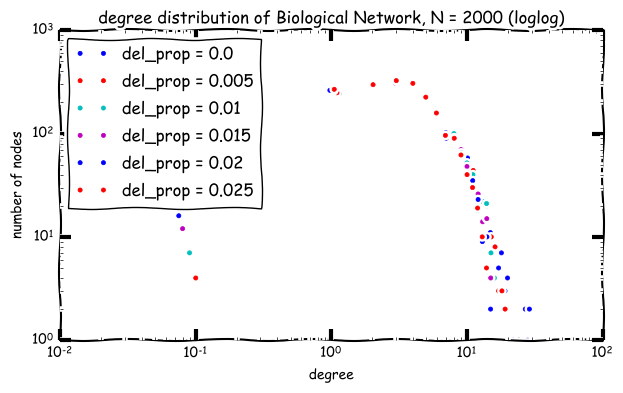

In [23]:
#degree distribution
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

for i in xrange(len(del_prop_set)):
    PDF = degree_distr(deg_bio_net[i])
    plt.loglog(PDF[1], PDF[0], '.',label = 'del_prop = %s' %del_prop_set[i])
    
ax.legend(loc='upper left')
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.title('degree distribution of Biological Network, N = %s (loglog)' %N_n)

Power law fulfilled.

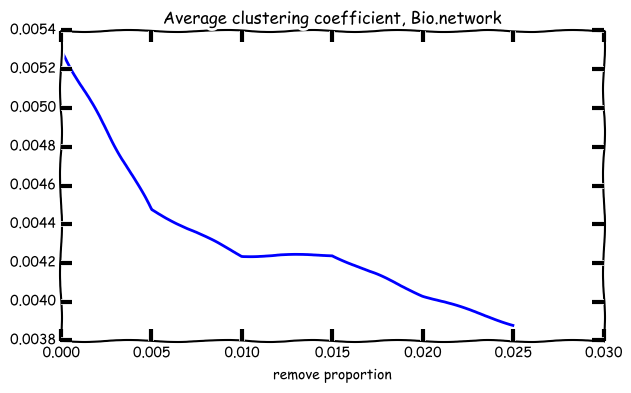

In [24]:
#average clustering coefficient (ACC) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

acc = []
for G in Models_bio_net: 
    acc.append(nx.average_clustering(G))
plt.plot(del_prop_set, acc, '-')

plt.xlabel('remove proportion')
plt.title('Average clustering coefficient, Bio.network')

Average clustering coefficient almost the same (near the 0).

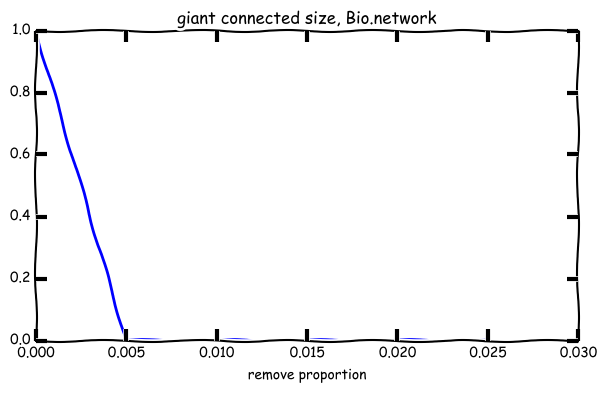

In [25]:
#giant connected size
#average clustering coefficient (ACC) to the number of nodes
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

GCC = []
for G in Models_bio_net: 
    Gc = max(nx.connected_component_subgraphs(G), key=len)
    GCC.append(Gc.number_of_nodes()/N_n)
plt.plot(del_prop_set, GCC, '-')

plt.xlabel('remove proportion')
plt.title('giant connected size, Bio.network')

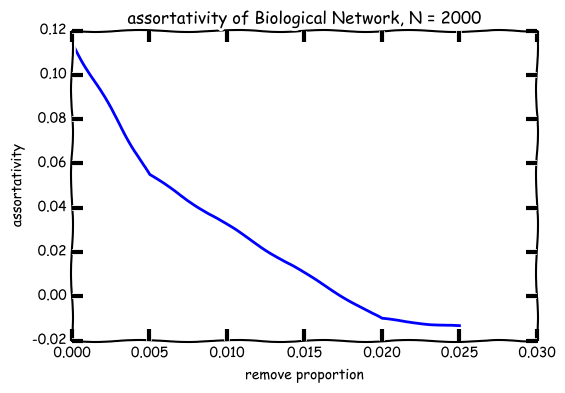

In [26]:
assort = [nx.degree_assortativity_coefficient(G) for G in Models_bio_net]

#fig = plt.figure(1, figsize=(7,4))
plt.plot(del_prop_set, assort, '-')
plt.xlabel('remove proportion')
plt.ylabel('assortativity')
plt.title('assortativity of Biological Network, N = %s' %N_n)

Assortativity coefficient decrease.

Indeed, we can see the effect of decreasing the assortativity in a stable way, while  a power-law degree distribution and the main properties of network's robustness remain.

In order to gather a deeper understanding of the mechanisms leading to the enhancement of degree correlation, we turn our attention to the average degree of the next neighbors of each network’s node. The average nearest-neighbors <k> degree of large-degree nodes is well above the average degree of the network, which means that large-degree nodes tend to connect with large-degree nodes rather than medium-degree (or small-degree) nodes. On its turn, this implies that large-degree nodes tend to contribute to an overall positive degree correlation, i.e., assortative mixing. On the other hand, also most of the small-degree nodes are able to form connections with large-degree nodes, thus contributing to a sort of negative degree correlation, i.e., disassortative mixing.

The delicate interplay between these two opposite tendencies is therefore responsible for the extremely week degree correlation of the overall network. The situation changes drastically for the network resulting from removing the largest-degree nodes. Now, the average nearest-neighbors degree of large-degree nodes oscillates around the average degree of networks, which implies that the initially positive degree correlation tendencies for these nodes is drastically reduced. As for the set of small-degree nodes, though the average degree of their nearest neighbors reduces a bit, yet they still unveil markedly negative degree correlation, and, as a result, the whole network displays a disassortative mixing pattern.

http://www.nature.com/articles/srep07536

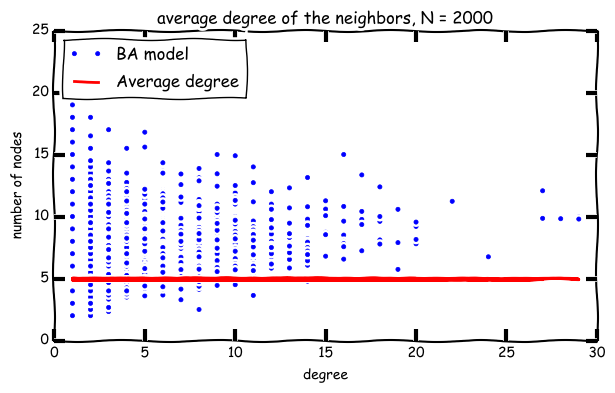

In [27]:
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

#the average degree of the neighborhood of each node
av_deg0 = (nx.average_neighbor_degree(Models_bio_net[0])).values()
#degrees
degrees0 = (Models_bio_net[0].degree()).values()
k_mean0 = np.mean(np.asarray(degrees0))*np.ones(len(degrees0))

plt.plot(degrees0,av_deg0,'.',label = 'BA model')
plt.plot(degrees0,k_mean0,'-',label = 'Average degree')
    
ax.legend(loc='upper left')
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.title('average degree of the neighbors, N = %s' %N_n)

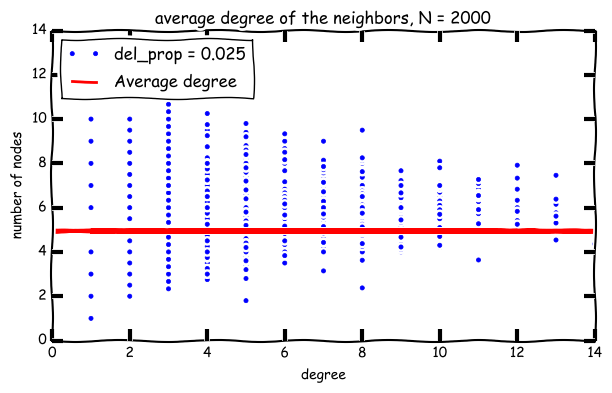

In [28]:
fig = plt.figure(1, figsize=(7,4))
ax = plt.subplot(111)

n = len(del_prop_set)-1
#the average degree of the neighborhood of each node
av_deg_n = (nx.average_neighbor_degree(Models_bio_net[n])).values()
#degrees
degrees_n = (Models_bio_net[n].degree()).values()
k_mean_n = np.mean(np.asarray(degrees0))*np.ones(len(degrees_n))

plt.plot(degrees_n,av_deg_n, '.',label = 'del_prop = %s' %del_prop_set[n])
plt.plot(degrees_n,k_mean_n,'-',label = 'Average degree')
    
ax.legend(loc='upper left')
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.title('average degree of the neighbors, N = %s' %N_n)

**Conclude:**

This model is generative model for disassortative growing scale-free networks.